In [1]:

from __future__ import print_function
import os
import cv2
import random 
import numpy as np
import keras
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import time

import matplotlib.pyplot as plt
name = "vgg16-model-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(name))

trainingImageGenerator = ImageDataGenerator(rescale = 1./255, shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
validationAndTestImageGenerator = ImageDataGenerator(rescale= 1./255)

%matplotlib inline






In [19]:
#get path names of each folder
test_normal_path = 'File Path here'
test_pneumonia_path = 'File Path here'

IMAGE_SIZE = 224
batch_size = 32
num_classes = 1

training_path = 'File Path here'
validation_path = 'File Path here'
test_path = 'File Path here'

training = trainingImageGenerator.flow_from_directory(training_path,target_size=(IMAGE_SIZE,IMAGE_SIZE),color_mode='grayscale',class_mode='binary',batch_size=batch_size)
validation = validationAndTestImageGenerator.flow_from_directory(validation_path,target_size=(IMAGE_SIZE,IMAGE_SIZE),color_mode='grayscale',class_mode='binary',batch_size=batch_size)
testing = validationAndTestImageGenerator.flow_from_directory(test_path,target_size=(IMAGE_SIZE,IMAGE_SIZE),color_mode='grayscale',class_mode='binary',batch_size=batch_size,shuffle=False)

print('image resizing all done')

Found 4099 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.
Found 586 images belonging to 2 classes.
image resizing all done


In [5]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)
print(tf.test.is_built_with_cuda()) 
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
2.4.1
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
VGG16Model = Sequential()

# CONV1: 64 3x3 filters with stride 3
VGG16Model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))

#224x224x64 CONV2: 64 3x3 filters with stride 3
VGG16Model.add(Conv2D(64, (3, 3), padding = 'same' , activation = 'relu'))

# MAX POOL1: 2x2 filters at stride 2
VGG16Model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))


#112x112x128 CONV2: 128 3x3 filters with stride 3
VGG16Model.add(Conv2D(128, (3, 3), padding = 'same' , activation = 'relu'))

#112x112x128 CONV2: 128 3x3 filters with stride 3
VGG16Model.add(Conv2D(128, (3, 3), padding = 'same' , activation = 'relu'))

# MAX POOL1: 2x2 filters at stride 2
VGG16Model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

#56x56x256 CONV2: 256 3x3 filters with stride 3
VGG16Model.add(Conv2D(256, (3, 3), padding = 'same' , activation = 'relu'))

#56x56x256 CONV2: 256 3x3 filters with stride 3
VGG16Model.add(Conv2D(256, (3, 3), padding = 'same' , activation = 'relu'))

#56x56x256 CONV2: 256 3x3 filters with stride 3
VGG16Model.add(Conv2D(256, (3, 3), padding = 'same' , activation = 'relu'))

# MAX POOL1: 2x2 filters at stride 2
VGG16Model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

#28x28x512 CONV2: 512 3x3 filters with stride 3
VGG16Model.add(Conv2D(512, (3, 3), padding = 'same' , activation = 'relu'))

#28x28x512 CONV2: 512 3x3 filters with stride 3
VGG16Model.add(Conv2D(512, (3, 3), padding = 'same' , activation = 'relu'))

#28x28x512 CONV2: 512 3x3 filters with stride 3
VGG16Model.add(Conv2D(512, (3, 3), padding = 'same' , activation = 'relu'))

# MAX POOL1: 2x2 filters at stride 2
VGG16Model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

#14x14x512 CONV2: 512 3x3 filters with stride 3
VGG16Model.add(Conv2D(512, (3, 3), padding = 'same' , activation = 'relu'))

#14x14x512 CONV2: 512 3x3 filters with stride 3
VGG16Model.add(Conv2D(512, (3, 3), padding = 'same' , activation = 'relu'))

#14x14x512 CONV2: 512 3x3 filters with stride 3
VGG16Model.add(Conv2D(512, (3, 3), padding = 'same' , activation = 'relu'))

# MAX POOL1: 2x2 filters at stride 2
VGG16Model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

# Flatten
VGG16Model.add(Flatten())

#[4096] FC6: 4096 neurons
VGG16Model.add(Dense(4096, activation = 'relu'))
VGG16Model.add(Dropout(0.5))

#[4096] FC7: 4096 neurons
VGG16Model.add(Dense(4096, activation = 'relu'))
VGG16Model.add(Dropout(0.5))

#[1000] FC8: 1000 neurons (class scores)
VGG16Model.add(Dense(num_classes, activation = 'sigmoid'))

VGG16Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [9]:
my_model = Sequential()

my_model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))

my_model.add(MaxPooling2D(pool_size = (2, 2)))

my_model.add(Conv2D(32, (3, 3), activation="relu"))

my_model.add(MaxPooling2D(pool_size = (2, 2)))

my_model.add(Conv2D(32, (3, 3), activation="relu"))

my_model.add(MaxPooling2D(pool_size = (2, 2)))

my_model.add(Conv2D(64, (3, 3), activation="relu"))

my_model.add(MaxPooling2D(pool_size = (2, 2)))

my_model.add(Conv2D(128, (3, 3), activation="relu"))

my_model.add(MaxPooling2D(pool_size = (2, 2)))

my_model.add(Flatten())
my_model.add(Dense(activation = 'relu', units = 128))
my_model.add(Dropout(0.2))
my_model.add(Dense(activation = 'sigmoid', units = 1))
my_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 24, 64)       

In [11]:
#model = VGG16Model
model = my_model


#checkpoint = ModelCheckpoint(filepath='vgg16_Weights.hdf5', monitor='val_loss', mode='min',save_best_only=True, save_weights_only=True)

weights = compute_class_weight('balanced', np.unique(training.classes), training.classes)
cw = dict(zip( np.unique(training.classes), weights))


# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.00005, decay=1e-6)


model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


model.fit(training,
              batch_size=batch_size,
              epochs=20,
              validation_data=validation,
              shuffle=True,
              class_weight=cw,
              callbacks=[tensorboard,checkpoint])



C:\Users\Cullan\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/20
129/129 [==============================] - 39s 288ms/step - loss: 0.7020 - accuracy: 0.2608 - val_loss: 0.6480 - val_accuracy: 0.6866
Epoch 2/20
129/129 [==============================] - 36s 282ms/step - loss: 0.6101 - accuracy: 0.7269 - val_loss: 0.5370 - val_accuracy: 0.7250
Epoch 3/20
129/129 [==============================] - 36s 280ms/step - loss: 0.4776 - accuracy: 0.8055 - val_loss: 0.3887 - val_accuracy: 0.8523
Epoch 4/20
129/129 [==============================] - 36s 279ms/step - loss: 0.3885 - accuracy: 0.8418 - val_loss: 0.3208 - val_accuracy: 0.8830
Epoch 5/20
129/129 [==============================] - 44s 339ms/step - loss: 0.3578 - accuracy: 0.8492 - val_loss: 0.2838 - val_accuracy: 0.8958
Epoch 6/20
129/129 [==============================] - 36s 280ms/step - loss: 0.3336 - accuracy: 0.8656 - val_loss: 0.3769 - val_accuracy: 0.8241
Epoch 7/20
129/129 [==============================] - 36s 280ms/step - loss: 0.3069 - accuracy: 0.8624 - val_loss: 0.2377 - val_ac

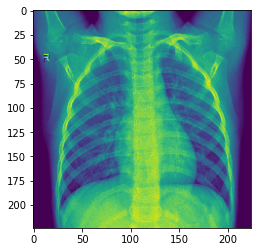

In [12]:
x = testing.next()
plt.imshow(x[0][0])

In [20]:
predictions = model.predict(testing)
predictions[predictions <= 0.5] = 0.
predictions[predictions > 0.5] = 1.
#print(predictions)
print(confusion_matrix(testing.classes, predictions))
print(model.evaluate(testing))


[[6.09166687e-03]
 [4.88463836e-03]
 [2.85957418e-02]
 [1.02988090e-02]
 [2.42545120e-02]
 [1.06551247e-02]
 [4.96960804e-02]
 [1.89013835e-02]
 [3.67105589e-03]
 [2.52669584e-03]
 [1.78770646e-02]
 [1.21097993e-02]
 [1.12440567e-02]
 [1.59150863e-03]
 [1.71923079e-02]
 [3.91150592e-03]
 [8.08735099e-03]
 [2.64548063e-02]
 [4.92585599e-02]
 [1.26053050e-01]
 [1.50392381e-02]
 [2.34576445e-02]
 [1.00680277e-01]
 [3.50040011e-02]
 [1.41836759e-02]
 [2.72922846e-03]
 [9.22900508e-04]
 [8.66397750e-03]
 [9.12735537e-02]
 [2.51014549e-02]
 [6.67862920e-03]
 [1.03701828e-02]
 [8.73590726e-03]
 [2.81627160e-02]
 [1.24628926e-02]
 [3.53485323e-03]
 [1.88773632e-01]
 [7.31023327e-02]
 [2.82514258e-03]
 [2.20711250e-02]
 [5.57956006e-03]
 [1.98640712e-02]
 [5.19709215e-02]
 [3.08564752e-02]
 [2.33253147e-02]
 [1.17984237e-02]
 [1.93141419e-02]
 [2.90894695e-02]
 [1.47225754e-03]
 [1.18419044e-01]
 [4.24771868e-02]
 [2.10083440e-01]
 [2.46161665e-03]
 [1.59615558e-02]
 [1.94841847e-02]
 [5.754067

19/19 [==============================] - 5s 240ms/step - loss: 0.1421 - accuracy: 0.9403
[0.14213016629219055, 0.9402730464935303]
